# Food Image Classification using CNN
This notebook demonstrates training a CNN model on Food-101 dataset

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Configuration
DATA_DIR = "food-101/images"
IMG_SIZE = 64
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 10
NUM_SAMPLES = 10000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
dataset.samples = dataset.samples[:NUM_SAMPLES]
dataset.targets = dataset.targets[:NUM_SAMPLES]

# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

Training samples: 8000
Validation samples: 2000
Number of classes: 101


In [4]:
# Model architecture
class FoodCNN(nn.Module):
    def __init__(self, num_classes, img_size=64):
        super(FoodCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Calculate feature size
        self.feature_size = self._get_feature_size(img_size)
        
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def _get_feature_size(self, img_size):
        x = torch.zeros(1, 3, img_size, img_size)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        return x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = FoodCNN(len(dataset.classes), img_size=IMG_SIZE).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 8460517 parameters


In [5]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Track metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [6]:
# Training loop
print("Starting training...\n")

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate metrics
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_acc = 100 * train_correct / train_total
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

print("Training completed!")

Starting training...

Epoch [1/10]
  Train Loss: 2.2355 | Train Acc: 28.91%
  Val Loss: 1.8343 | Val Acc: 35.70%

Epoch [2/10]
  Train Loss: 1.8304 | Train Acc: 35.15%
  Val Loss: 1.7354 | Val Acc: 39.25%

Epoch [3/10]
  Train Loss: 1.7439 | Train Acc: 37.70%
  Val Loss: 1.6862 | Val Acc: 41.20%

Epoch [4/10]
  Train Loss: 1.6765 | Train Acc: 40.56%
  Val Loss: 1.6152 | Val Acc: 44.60%

Epoch [5/10]
  Train Loss: 1.5892 | Train Acc: 43.17%
  Val Loss: 1.6875 | Val Acc: 42.35%

Epoch [6/10]
  Train Loss: 1.4979 | Train Acc: 46.23%
  Val Loss: 1.5275 | Val Acc: 46.15%

Epoch [7/10]
  Train Loss: 1.4104 | Train Acc: 49.45%
  Val Loss: 1.5093 | Val Acc: 47.10%

Epoch [8/10]
  Train Loss: 1.3297 | Train Acc: 51.84%
  Val Loss: 1.5335 | Val Acc: 47.15%

Epoch [9/10]
  Train Loss: 1.2532 | Train Acc: 55.01%
  Val Loss: 1.5666 | Val Acc: 46.95%

Epoch [10/10]
  Train Loss: 1.1554 | Train Acc: 57.56%
  Val Loss: 1.5120 | Val Acc: 49.80%

Training completed!


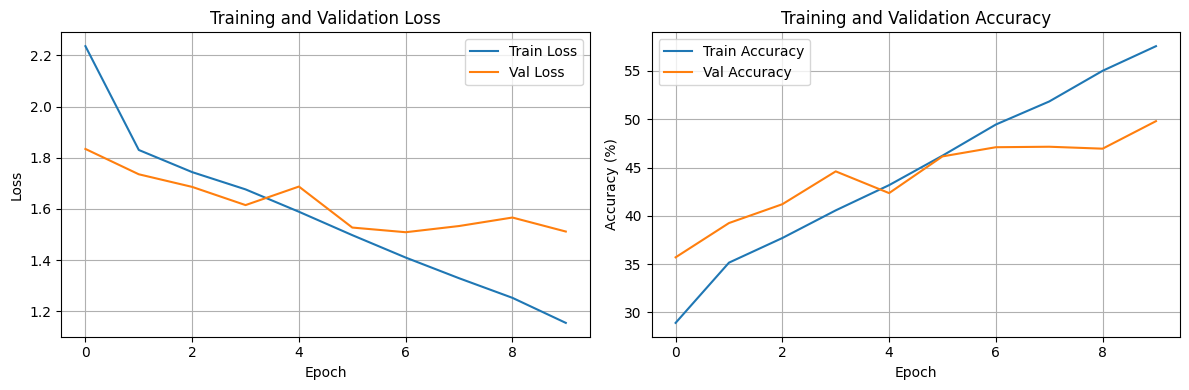

In [7]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Save model
torch.save(model.state_dict(), 'food_classifier.pth')
print("Model saved successfully!")

Model saved successfully!
